# A Rahul  
# 20BRS1102

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
!wget --no-check-certificate \
    "https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip" \
    -O "cats-and-dogs.zip"

--2023-03-19 14:32:27--  https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/laxmimerit/dog-cat-full-dataset/zip/refs/heads/master [following]
--2023-03-19 14:32:27--  https://codeload.github.com/laxmimerit/dog-cat-full-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cats-and-dogs.zip’

cats-and-dogs.zip       [               <=>  ] 545.70M  31.6MB/s    in 18s     

2023-03-19 14:32:45 (30.9 MB/s) - ‘cats-and-dogs.zip’ saved [572212372]



In [ ]:
zip_ref = zipfile.ZipFile('cats-and-dogs.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
train_path="/content/dog-cat-full-dataset-master/data/train"
test_path="/content/dog-cat-full-dataset-master/data/test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [ ]:
print(class_names)
print(class_names_test)

['cats', 'dogs']
['cats', 'dogs']


#Dataset Images

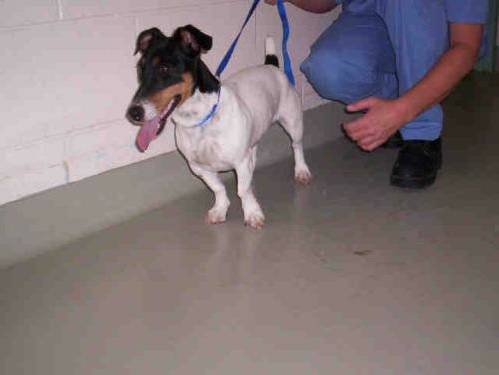

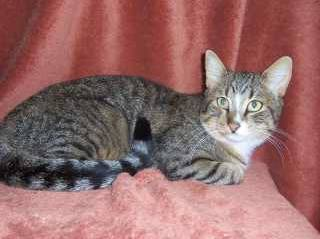

In [ ]:
image_dog=cv2.imread("/content/dog-cat-full-dataset-master/data/test/dogs/dog.10025.jpg")
cv2_imshow(image_dog)
image_cat=cv2.imread("/content/dog-cat-full-dataset-master/data/test/cats/cat.10004.jpg")
cv2_imshow(image_cat)

#Preparation of Dataets

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/dog-cat-full-dataset-master/data/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/dog-cat-full-dataset-master/data/test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/\
v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        TF_WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        md5_hash='a268eb855778b3df3c7506639542a6af')
base_model.load_weights(weights_path)

94653016/94653016 [==============================] - 1s 0us/step


In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
# for layer in base_model.layers:
#     layer.trainable = False

top_num = 4
for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
best_model = ModelCheckpoint("resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
  model.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[best_model, TensorBoard(log_dir='./logs', histogram_freq=1)])
  # H = model.fit(train_generator,validation_data=test_generator,epochs=10,verbose=1,callbacks=[mc,es])

<ipython-input-82-939fc3d105fc>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8440

625/625 [==============================] - 314s 481ms/step - loss: 0.3530 - accuracy: 0.8440 - val_loss: 0.7466 - val_accuracy: 0.5000
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9326

625/625 [==============================] - 301s 481ms/step - loss: 0.1683 - accuracy: 0.9326 - val_loss: 0.8102 - val_accuracy: 0.5000
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9478

625/625 [==============================] - 303s 485ms/step - loss: 0.1305 - accuracy: 0.9478 - val_loss: 0.8566 - val_accuracy: 0.5000
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9539

625/625 [==============================] - 299s 479ms/step - loss: 0.1151 - accuracy: 0.9539 - val_loss: 0.8765 - val_accuracy: 0.5000
Epoch 5/10
625/625 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9576

625/625 [==============================] - 297s 475ms/step - loss: 0.1058 - accuracy: 0.9576 - val_loss: 0.8903 - val_accuracy: 0.5000
Epoch 6/10
625/625 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9596

625/625 [==============================] - 297s 475ms/step - loss: 0.0993 - accuracy: 0.9596 - val_loss: 0.8970 - val_accuracy: 0.5000
Epoch 7/10
625/625 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9617

625/625 [==============================] - 299s 478ms/step - loss: 0.0972 - accuracy: 0.9617 - val_loss: 0.8952 - val_accuracy: 0.5000
Epoch 8/10
625/625 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9643

625/625 [==============================] - 293s 469ms/step - loss: 0.0892 - accuracy: 0.9643 - val_loss: 0.8997 - val_accuracy: 0.5000
Epoch 9/10
625/625 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9634

625/625 [==============================] - 293s 468ms/step - loss: 0.0889 - accuracy: 0.9634 - val_loss: 0.8988 - val_accuracy: 0.5000
Epoch 10/10
625/625 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9653

625/625 [==============================] - 296s 473ms/step - loss: 0.0855 - accuracy: 0.9653 - val_loss: 0.8951 - val_accuracy: 0.5000


The Accuracy of the Resnet model for the dog-cat classification dataset was found to be 96% in just 10 epochs.